In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from gaussian_splatting.colmap import parse_cameras, parse_images, parse_points3d, clean_text
from gaussian_splatting.model import View, GaussianCloud, train
from gaussian_splatting.model.util import create_rasterizer

random.seed(42)

In [2]:
dataset = "mug"

In [3]:
# parsing colmap output
images = {
    image_name: cv2.imread(f"../data/{dataset}/images/{image_name}")[:, :, ::-1] / 255
    for image_name in os.listdir(f"../data/{dataset}/images/")
}
with open(f"../data/{dataset}/cameras.txt", "r")  as f:
    cameras = parse_cameras(clean_text(f.readlines()))

with open(f"../data/{dataset}/points3D.txt", "r")  as f:
    points3d = parse_points3d(clean_text(f.readlines()))

with open(f"../data/{dataset}/images.txt", "r")  as f:
    images = parse_images(clean_text(f.readlines()), cameras, points3d, images)
    

In [4]:
# creating views
views = [View.from_image(image) for image in images.values()]
views[:4]

[View at (-4.556993807129905, -0.9313693722101806, 2.5789579896172965),
 View at (-4.528663378471228, -0.941764286253878, 2.584633192416664),
 View at (-4.526011778064431, -0.9219977291723718, 2.551652844623281),
 View at (-4.5220420310393825, -0.9183180827188233, 2.5293994457516717)]

In [5]:
# train/test splitting of views
random.shuffle(views)
train_split = 0.7
dataset_size = len(views)
train_dataset = views[:int(dataset_size*train_split)]
test_dataset = views[int(dataset_size*train_split):]

In [6]:
gaussian_cloud = GaussianCloud.from_point_cloud([*points3d.values()]).to("cuda")
gaussian_cloud

Gaussian Cloud of 4864 points in cuda:0

In [7]:
def compare(view: View, gaussian_cloud: GaussianCloud):
    gaussian_cloud.eval()
    model = create_rasterizer(view)
    _img, _ = model(**gaussian_cloud.parameters)
    npimg = _img.cpu().detach().numpy().transpose([1, 2, 0])
    orig_img = view.image
    plt.imshow(np.hstack([npimg, orig_img]))
    plt.show()

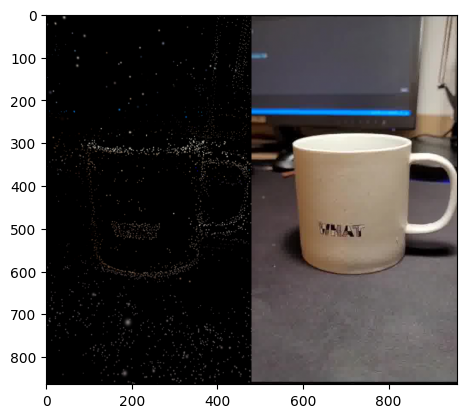

In [8]:
compare(test_dataset[1], gaussian_cloud)

In [9]:
gaussian_cloud.train()
train_losses, test_losses = train(gaussian_cloud, train_dataset, test_dataset, epochs=300)

  10:  loss=0.218394
  20:  loss=0.131174
  30:  loss=0.105610
  40:  loss=0.091119
  50:  loss=0.082295
  60:  loss=0.076442
  70:  loss=0.072180
  80:  loss=0.068152
  90:  loss=0.065186
 100:  loss=0.062459
 110:  loss=0.065959
 120:  loss=0.061168
 130:  loss=0.058663
 140:  loss=0.056973
 150:  loss=0.055285
 160:  loss=0.053460
 170:  loss=0.052614
 180:  loss=0.051769
 190:  loss=0.051208
 200:  loss=0.050819
 210:  loss=0.055386
 220:  loss=0.052422
 230:  loss=0.050032
 240:  loss=0.049340
 250:  loss=0.049362
 260:  loss=0.049096
 270:  loss=0.048749
 280:  loss=0.049707
 290:  loss=0.048714


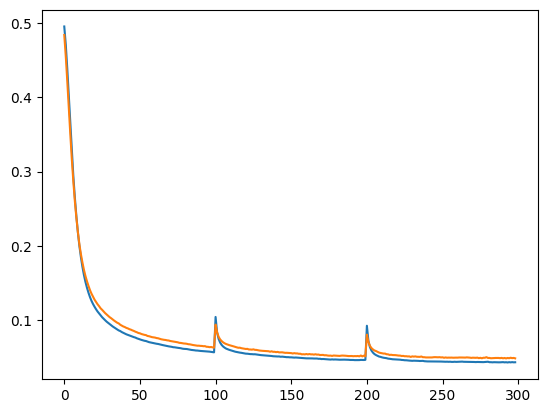

In [10]:
plt.plot(train_losses)
plt.plot(test_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


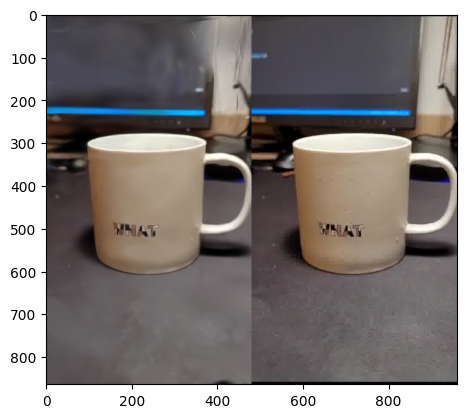

In [11]:
compare(test_dataset[1], gaussian_cloud)

In [12]:
gaussian_cloud.save(f"../models/{dataset}.pkl")